# Optimal Sensor Placement Using Modal Analysis Based Approaches

This notebook demonstrates optimal sensor placement algorithms for structural health monitoring using modal analysis data. We explore two methods:

1. **Fisher Information Matrix with Effective Independence (EI) Method**
2. **Maximum Norm Method with spatial constraints**

## Introduction

Computes the 12-sensor optimal arrangements using the Fisher information method and the maximum norm method, plotting the resulting arrangements on the structure's geometry.

### References

- D. Kammer, "Sensor placement for on-orbit modal identification and correlation of large space structures," *Journal of Guidance, Control, and Dynamics*, vol. 14, pp. 251-259, 1991.
- M. Meo and G. Zumpano, "On the optimal sensor placement techniques for a bridge structure," *Engineering Structures*, vol. 27, pp. 1488-1497, 2005.

### SHMTools functions demonstrated

- `response_interp_shm`: Convert DOF response to node XYZ coordinates
- `add_resp_2_geom_shm`: Add response to geometry for deformed shape visualization
- `osp_fisher_info_eiv_shm`: Fisher Information Matrix optimization
- `get_sensor_layout_shm`: Convert optimal DOFs to sensor locations
- `osp_max_norm_shm`: Maximum norm optimization with spatial constraints

## Setup and Imports

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Import shmtools (installed package)
from examples.data import import_modal_osp_shm
from shmtools.modal import (
    response_interp_shm,
    add_resp_2_geom_shm,
    osp_fisher_info_eiv_shm,
    get_sensor_layout_shm,
    osp_max_norm_shm
)

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Setup complete!")

Setup complete!


## Load Example Modal Data

Loads nodeLayout, elements, modeshapes, and respDOF from the example dataset.

In [2]:
# Load modal OSP example data
node_layout, elements, mode_shapes, resp_dof = import_modal_osp_shm()

print(f"Loaded data:")
print(f"  Node layout shape: {node_layout.shape}")
print(f"  Elements shape: {elements.shape}")
print(f"  Mode shapes: {mode_shapes.shape}")
print(f"  Response DOF: {resp_dof.shape}")
print(f"\nNumber of nodes: {node_layout.shape[1]}")
print(f"Number of modes: {mode_shapes.shape[1]}")
print(f"Number of DOFs: {mode_shapes.shape[0]}")

Loaded data:
  Node layout shape: (4, 420)
  Elements shape: (9, 216)
  Mode shapes: (1260, 13)
  Response DOF: (1260, 2)

Number of nodes: 420
Number of modes: 13
Number of DOFs: 1260


## Visualization Functions

Define functions for plotting the structure, mode shapes, and sensor locations.

In [3]:
def plot_structure_3d(node_layout, elements, ax=None, color='blue', alpha=0.3):
    """Plot 3D structure using nodes and elements."""
    if ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
    
    # Handle different node layout formats
    if node_layout.shape[0] == 4:
        # Format: [node_indices; X; Y; Z]
        node_xyz = node_layout[1:4, :].T  # Extract X,Y,Z and transpose
    else:
        # Format: [X, Y, Z] per row
        node_xyz = node_layout
    
    # Handle different element formats
    if elements.ndim == 2 and elements.shape[0] > 4:
        # Transpose if needed
        elements = elements.T
    
    # Plot elements as lines
    for i in range(elements.shape[0]):
        element = elements[i, :]
        # Filter out zeros or invalid indices
        valid_indices = element[element > 0].astype(int) - 1  # Convert to 0-based
        
        if len(valid_indices) > 1:
            # Get coordinates of element nodes
            element_nodes = node_xyz[valid_indices]
            
            # Close the element by adding first node at end
            element_nodes = np.vstack([element_nodes, element_nodes[0]])
            
            # Plot element
            ax.plot(element_nodes[:, 0], 
                    element_nodes[:, 1],
                    element_nodes[:, 2], 
                    color=color, alpha=alpha)
    
    # Plot nodes
    ax.scatter(node_xyz[:, 0],
               node_xyz[:, 1], 
               node_xyz[:, 2],
               c='red', s=20, alpha=0.6)
    
    return ax


def plot_mode_shape(node_layout, elements, mode_shape, resp_dof, mode_num, scale=None):
    """Plot deformed shape for a given mode."""
    # Convert mode shape DOF vector to node XYZ response
    resp_xyz = response_interp_shm(node_layout, mode_shape, resp_dof, use_3d_interp=False)
    
    # Add response to geometry for deformed shape
    deformed_layout, resp_scale = add_resp_2_geom_shm(node_layout, resp_xyz, scale)
    
    # Create figure
    fig = plt.figure(figsize=(12, 5))
    
    # Plot original shape
    ax1 = fig.add_subplot(121, projection='3d')
    plot_structure_3d(node_layout, elements, ax1, color='blue', alpha=0.3)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(f'Original Structure')
    
    # Plot deformed shape
    ax2 = fig.add_subplot(122, projection='3d')
    plot_structure_3d(deformed_layout, elements, ax2, color='red', alpha=0.5)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_title(f'Mode {mode_num} (scale: {resp_scale:.2f})')
    
    plt.tight_layout()
    return fig


def plot_sensors_on_structure(node_layout, elements, sensor_layout, title='Sensor Placement'):
    """Plot sensor locations on the structure."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot structure
    plot_structure_3d(node_layout, elements, ax, color='blue', alpha=0.2)
    
    # Plot sensors
    ax.scatter(sensor_layout[:, 0],
               sensor_layout[:, 1],
               sensor_layout[:, 2],
               c='red', s=200, marker='o', edgecolors='black', linewidth=2,
               label=f'{len(sensor_layout)} sensors')
    
    # Add sensor numbers
    for i, pos in enumerate(sensor_layout):
        ax.text(pos[0], pos[1], pos[2], f'  S{i+1}', fontsize=8)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    
    return fig

## Plot Mode Shapes

Convert the 3rd and 10th 1D mode vectors to 2D response arrays using degree of freedom (DOF) definitions in respDOF.

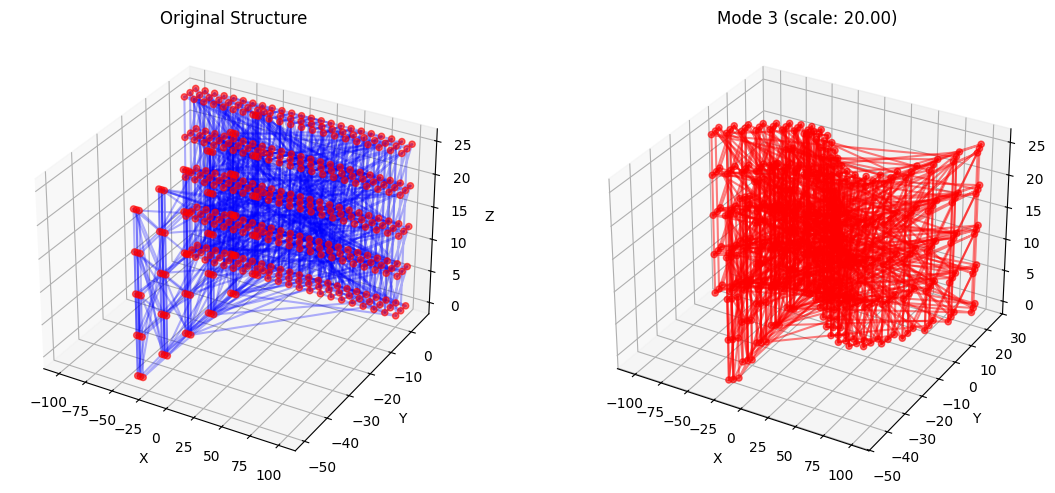

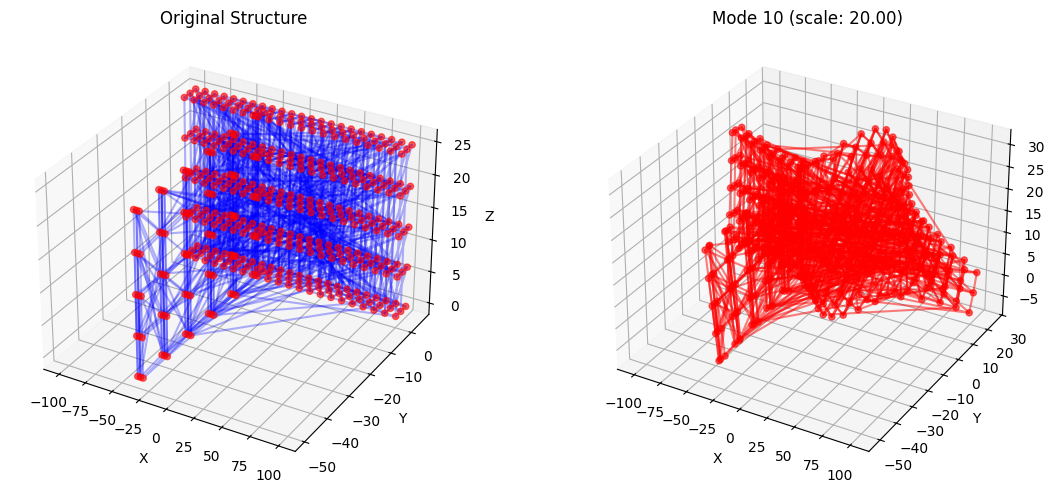

In [4]:
# Plot Mode 3
mode3 = mode_shapes[:, 2]  # 3rd mode (0-based indexing)
fig3 = plot_mode_shape(node_layout, elements, mode3, resp_dof, mode_num=3)
plt.show()

# Plot Mode 10  
mode10 = mode_shapes[:, 9]  # 10th mode (0-based indexing)
fig10 = plot_mode_shape(node_layout, elements, mode10, resp_dof, mode_num=10)
plt.show()

## OSP Fisher Information Matrix, Effective Independence Method

Calculate the 12 optimal DOFs to place sensors by maximizing the determinant of the Fisher Information Matrix using the Effective Independence Method.

The Effective Independence (EI) method iteratively removes degrees of freedom that contribute least to the observability of the target modes.

In [5]:
# Set parameters
num_sensors = 12
cov_matrix = None  # Use identity matrix

# Run Fisher Information EI optimization
print("Running Fisher Information EI optimization...")
op_list_fisher, det_q = osp_fisher_info_eiv_shm(num_sensors, mode_shapes, cov_matrix)

print(f"\nOptimal DOF indices (1-based): {op_list_fisher}")
print(f"Number of iterations: {len(det_q)}")
print(f"Final determinant of Q: {det_q[-1]:.2e}")

Running Fisher Information EI optimization...


/Users/eric/repo/shm/shmtools/modal/osp.py:283: RuntimeWarning: divide by zero encountered in matmul
  eid = np.diag(phi_c @ q_inv @ phi_c.T)
/Users/eric/repo/shm/shmtools/modal/osp.py:283: RuntimeWarning: overflow encountered in matmul
  eid = np.diag(phi_c @ q_inv @ phi_c.T)
/Users/eric/repo/shm/shmtools/modal/osp.py:283: RuntimeWarning: invalid value encountered in matmul
  eid = np.diag(phi_c @ q_inv @ phi_c.T)



Optimal DOF indices (1-based): [  1  12  71 451 453 458 467 554 751 754 874 878]
Number of iterations: 1249
Final determinant of Q: 4.79e-02


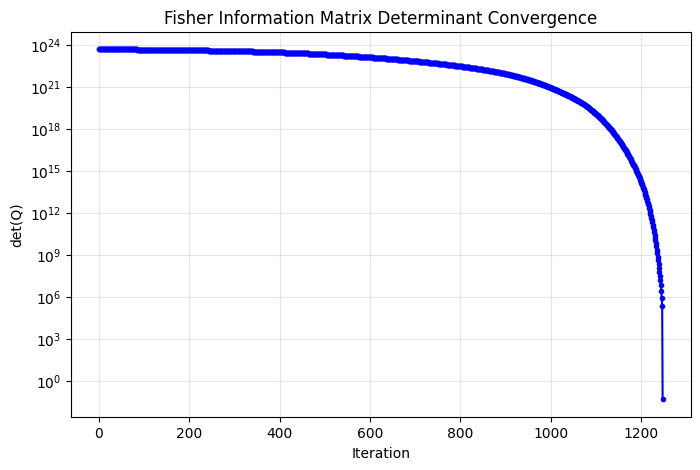

In [6]:
# Plot convergence of determinant
plt.figure(figsize=(8, 5))
plt.semilogy(det_q, 'b.-')
plt.xlabel('Iteration')
plt.ylabel('det(Q)')
plt.title('Fisher Information Matrix Determinant Convergence')
plt.grid(True, alpha=0.3)
plt.show()

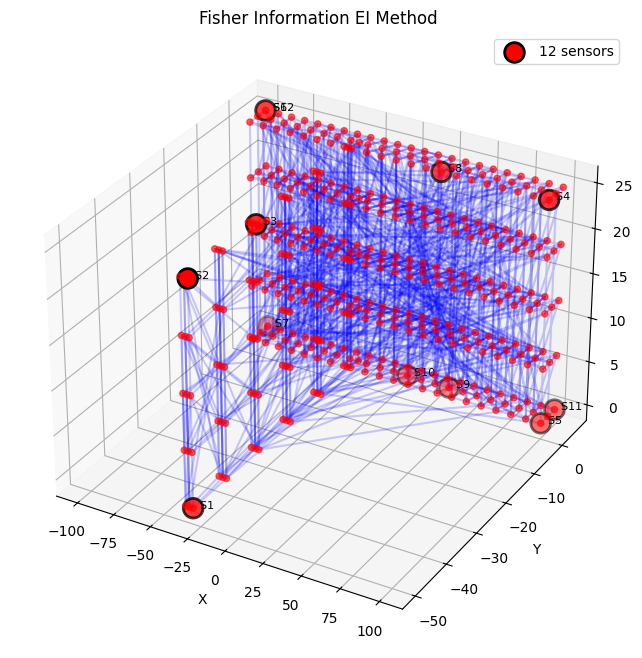


Sensor coordinates (Fisher Information EI):
  Sensor 1: X=-30.00, Y=-50.00, Z=0.00
  Sensor 2: X=-30.00, Y=-50.00, Z=25.00
  Sensor 3: X=-30.00, Y=-30.00, Z=25.00
  Sensor 4: X=100.00, Y=0.00, Z=25.00
  Sensor 5: X=100.00, Y=0.00, Z=0.00
  Sensor 6: X=-100.00, Y=5.00, Z=25.00
  Sensor 7: X=-100.00, Y=5.00, Z=0.00
  Sensor 8: X=30.00, Y=0.00, Z=25.00
  Sensor 9: X=33.18, Y=2.50, Z=0.00
  Sensor 10: X=4.55, Y=2.50, Z=0.00
  Sensor 11: X=100.00, Y=5.00, Z=0.00
  Sensor 12: X=-100.00, Y=5.00, Z=25.00


In [7]:
# Convert optimal DOF indices to sensor XYZ locations
sensor_layout_fisher = get_sensor_layout_shm(op_list_fisher, resp_dof, node_layout)

# Plot sensors on structure
fig_fisher = plot_sensors_on_structure(node_layout, elements, sensor_layout_fisher,
                                      title='Fisher Information EI Method')
plt.show()

print(f"\nSensor coordinates (Fisher Information EI):")
for i, pos in enumerate(sensor_layout_fisher):
    print(f"  Sensor {i+1}: X={pos[0]:.2f}, Y={pos[1]:.2f}, Z={pos[2]:.2f}")

## OSP Maximum Norm Method

Calculate the 12 optimal DOFs to place sensors by maximizing the norm of the response. The influence of the modes are weighted linearly. Sensors which are closer than a distance of 20 are "dueled" to maintain a minimum separation.

This method prioritizes locations with high modal response while ensuring sensors are spatially distributed.

In [8]:
# Set parameters for Maximum Norm method
num_sensors = 12
weights = np.arange(13, 0, -1)  # Linear weights: 13, 12, 11, ..., 1
dualing_distance = 20.0  # Minimum separation between sensors

print(f"Mode weights: {weights}")
print(f"Minimum sensor separation: {dualing_distance}")

# Run Maximum Norm optimization
print("\nRunning Maximum Norm optimization...")
op_list_maxnorm = osp_max_norm_shm(num_sensors, mode_shapes, weights, 
                                   dualing_distance, resp_dof, node_layout)

print(f"\nOptimal DOF indices (1-based): {op_list_maxnorm}")

Mode weights: [13 12 11 10  9  8  7  6  5  4  3  2  1]
Minimum sensor separation: 20.0

Running Maximum Norm optimization...

Optimal DOF indices (1-based): [451 453 458 467   1  12 546 549 541 554 544 551]


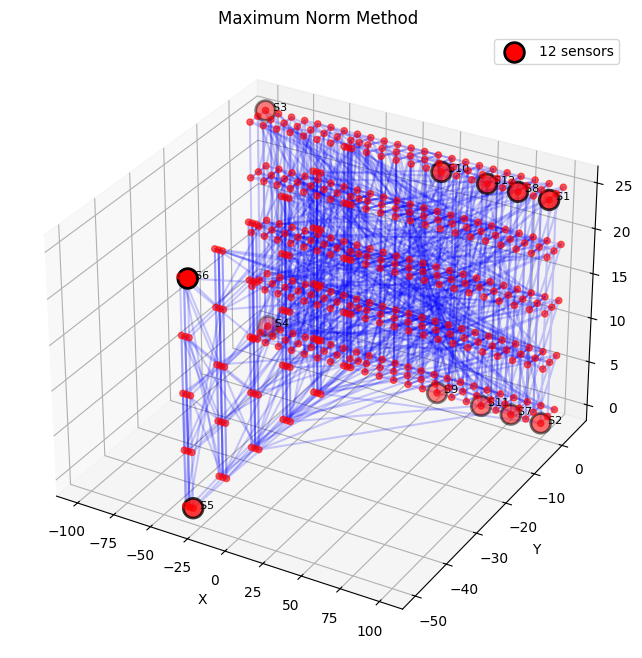


Sensor coordinates (Maximum Norm):
  Sensor 1: X=100.00, Y=0.00, Z=25.00
  Sensor 2: X=100.00, Y=0.00, Z=0.00
  Sensor 3: X=-100.00, Y=5.00, Z=25.00
  Sensor 4: X=-100.00, Y=5.00, Z=0.00
  Sensor 5: X=-30.00, Y=-50.00, Z=0.00
  Sensor 6: X=-30.00, Y=-50.00, Z=25.00
  Sensor 7: X=80.00, Y=0.00, Z=0.00
  Sensor 8: X=80.00, Y=0.00, Z=25.00
  Sensor 9: X=30.00, Y=0.00, Z=0.00
  Sensor 10: X=30.00, Y=0.00, Z=25.00
  Sensor 11: X=60.00, Y=0.00, Z=0.00
  Sensor 12: X=60.00, Y=0.00, Z=25.00


In [9]:
# Convert optimal DOF indices to sensor XYZ locations
sensor_layout_maxnorm = get_sensor_layout_shm(op_list_maxnorm, resp_dof, node_layout)

# Plot sensors on structure
fig_maxnorm = plot_sensors_on_structure(node_layout, elements, sensor_layout_maxnorm,
                                       title='Maximum Norm Method')
plt.show()

print(f"\nSensor coordinates (Maximum Norm):")
for i, pos in enumerate(sensor_layout_maxnorm):
    print(f"  Sensor {i+1}: X={pos[0]:.2f}, Y={pos[1]:.2f}, Z={pos[2]:.2f}")

## Compare Methods

Compare the sensor placements from both methods side by side.

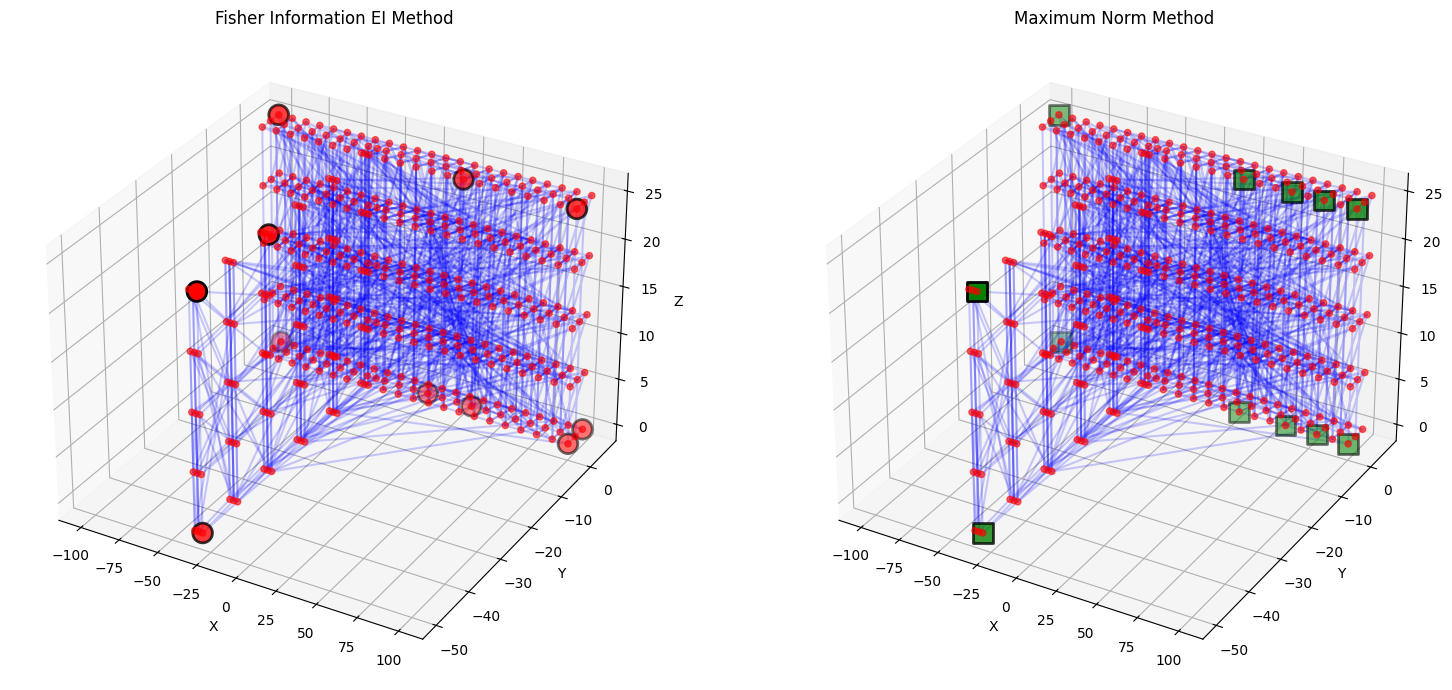

In [10]:
# Create comparison plot
fig = plt.figure(figsize=(16, 7))

# Fisher Information method
ax1 = fig.add_subplot(121, projection='3d')
plot_structure_3d(node_layout, elements, ax1, color='blue', alpha=0.2)
ax1.scatter(sensor_layout_fisher[:, 0],
            sensor_layout_fisher[:, 1],
            sensor_layout_fisher[:, 2],
            c='red', s=200, marker='o', edgecolors='black', linewidth=2)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Fisher Information EI Method')

# Maximum Norm method
ax2 = fig.add_subplot(122, projection='3d')
plot_structure_3d(node_layout, elements, ax2, color='blue', alpha=0.2)
ax2.scatter(sensor_layout_maxnorm[:, 0],
            sensor_layout_maxnorm[:, 1],
            sensor_layout_maxnorm[:, 2],
            c='green', s=200, marker='s', edgecolors='black', linewidth=2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Maximum Norm Method')

plt.tight_layout()
plt.show()

## Analysis of Results

Calculate metrics to compare the two sensor placement methods.

In [11]:
# Calculate average minimum distance between sensors for each method
def calc_min_distances(sensor_layout):
    """Calculate minimum distance from each sensor to its nearest neighbor."""
    n_sensors = len(sensor_layout)
    min_distances = np.zeros(n_sensors)
    
    for i in range(n_sensors):
        distances = []
        for j in range(n_sensors):
            if i != j:
                dist = np.linalg.norm(sensor_layout[i] - sensor_layout[j])
                distances.append(dist)
        min_distances[i] = np.min(distances)
    
    return min_distances

# Calculate metrics for Fisher Information method
min_dist_fisher = calc_min_distances(sensor_layout_fisher)
avg_min_dist_fisher = np.mean(min_dist_fisher)
std_min_dist_fisher = np.std(min_dist_fisher)

print("Fisher Information EI Method:")
print(f"  Average minimum distance: {avg_min_dist_fisher:.2f}")
print(f"  Std deviation: {std_min_dist_fisher:.2f}")
print(f"  Min distance: {np.min(min_dist_fisher):.2f}")
print(f"  Max distance: {np.max(min_dist_fisher):.2f}")

# Calculate metrics for Maximum Norm method
min_dist_maxnorm = calc_min_distances(sensor_layout_maxnorm)
avg_min_dist_maxnorm = np.mean(min_dist_maxnorm)
std_min_dist_maxnorm = np.std(min_dist_maxnorm)

print("\nMaximum Norm Method:")
print(f"  Average minimum distance: {avg_min_dist_maxnorm:.2f}")
print(f"  Std deviation: {std_min_dist_maxnorm:.2f}")
print(f"  Min distance: {np.min(min_dist_maxnorm):.2f}")
print(f"  Max distance: {np.max(min_dist_maxnorm):.2f}")
print(f"  Enforced minimum: {dualing_distance:.2f}")

Fisher Information EI Method:
  Average minimum distance: 17.02
  Std deviation: 10.61
  Min distance: 0.00
  Max distance: 28.64

Maximum Norm Method:
  Average minimum distance: 22.50
  Std deviation: 2.50
  Min distance: 20.00
  Max distance: 25.00
  Enforced minimum: 20.00


In [12]:
# Calculate observability metrics
def calc_observability_metric(mode_shapes, dof_indices):
    """Calculate observability metric for selected DOFs."""
    # Convert to 0-based indexing
    dof_idx_0 = dof_indices.astype(int) - 1
    
    # Extract mode shapes at selected DOFs
    phi_selected = mode_shapes[dof_idx_0, :]
    
    # Calculate Fisher Information Matrix
    q_matrix = phi_selected.T @ phi_selected
    
    # Calculate metrics
    det_q = np.linalg.det(q_matrix)
    cond_q = np.linalg.cond(q_matrix)
    
    return det_q, cond_q

# Calculate for both methods
det_fisher, cond_fisher = calc_observability_metric(mode_shapes, op_list_fisher)
det_maxnorm, cond_maxnorm = calc_observability_metric(mode_shapes, op_list_maxnorm)

print("\nObservability Metrics:")
print(f"\nFisher Information EI:")
print(f"  det(Q): {det_fisher:.2e}")
print(f"  cond(Q): {cond_fisher:.2e}")
print(f"\nMaximum Norm:")
print(f"  det(Q): {det_maxnorm:.2e}")
print(f"  cond(Q): {cond_maxnorm:.2e}")


Observability Metrics:

Fisher Information EI:
  det(Q): 4.51e-02
  cond(Q): 6.96e+07

Maximum Norm:
  det(Q): -7.78e-13
  cond(Q): 1.96e+08


## Summary

This notebook demonstrated two optimal sensor placement methods for structural health monitoring:

### Fisher Information EI Method
- **Objective**: Maximize determinant of Fisher Information Matrix
- **Approach**: Iteratively remove DOFs with smallest contribution to observability
- **Advantages**: Optimal from information theory perspective, maximizes mode observability
- **Disadvantages**: May cluster sensors in high-response regions

### Maximum Norm Method
- **Objective**: Maximize weighted modal response norm with spatial constraints
- **Approach**: Greedy selection with minimum separation enforcement
- **Advantages**: Ensures spatial distribution, practical for real installations
- **Disadvantages**: May sacrifice some observability for spatial coverage

### Key Findings
1. Fisher Information method typically achieves higher observability metrics (det(Q))
2. Maximum Norm method provides better spatial distribution with enforced minimum separation
3. Choice of method depends on application priorities (information vs. coverage)

Both methods are valuable tools for designing sensor networks in structural health monitoring applications.